In [1]:
import pandas as pd
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import seaborn as sns

from matplotlib import gridspec
from matplotlib import pyplot as plt
from IPython.display import Image, HTML
from datetime import datetime
from plotly import express as px
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Add to dataset the informations below:
 - Place ID: ocation identification
 - OSM Type: Open Street Map type
 - Country: Contry name
 - Country Code: Country code

In [2]:
#from geopy.geocoders import Nominatim
data = pd.read_csv('/Users/anaotavio/Documents/repos/house_sales/data/kc_house_data.csv') 

# the task will be delivered in parallel processing
import time
import defs
from multiprocessing import Pool

data['query'] = data[['lat', 'long']].apply( lambda x: str( x['lat'] ) + ',' + str( x['long'] ), axis=1 )
df1 = data[['id', 'query']].head()

p = Pool(2)
start = time.process_time()
df1[['place_id', 'osm_type', 'country', 'country_code']] = p.map( defs.get_data, df1.iterrows() )
print(time.process_time() - start)

0.017975999999999992


In [3]:
df1.head()

,id,query,place_id,osm_type,country,country_code
0,7129300520,"47.5112,-122.257",161022547,way,United States,us
1,6414100192,"47.721,-122.319",160016678,way,United States,us
2,5631500400,"47.7379,-122.233",74951055,node,United States,us
3,2487200875,"47.5208,-122.393",156726151,way,United States,us
4,1954400510,"47.6168,-122.045",296045104,way,United States,us


# Add the filters below to the Map:
 - Minimum size sqft_living
 - Minimum number of bathrooms
 - Maximum price value
 - Maximum size sqft_basement
 - Filter conditions properties
 - Filter per yr_built

In [11]:
data['is_waterfront'] = data['waterfront'].apply(lambda x:'yes' if x==1 else 'no')

# define interactive buttons
price_limit = widgets.IntSlider(
    value= int(data['price'].mean()),
    min = int(data['price'].min()),
    max = int(data['price'].max()),
    step = 1,
    description = 'Maximum Price',
    disable = False,
    style ={'description_width': 'initial'})

livingroom_limit = widgets.IntSlider(
    value= int(data['sqft_living'].mean()),
    min = int(data['sqft_living'].min()),
    max = int(data['sqft_living'].max()),
    step = 1,
    description = 'Minimum Living Room Size',
    disable = False,
    style ={'description_width': 'initial'})


bathroom_limit = widgets.IntSlider(
    value= int(data['bathrooms'].mean()),
    min = int(data['bathrooms'].min()),
    max = int(data['bathrooms'].max()),
    step = 1,
    description = 'Minimum Bathrooms Values',
    disable = False,
    style ={'description_width': 'initial'})


basement_limit = widgets.IntSlider(
    value= int(data['sqft_basement'].mean()),
    min = int(data['sqft_basement'].min()),
    max = int(data['sqft_basement'].max()),
    step = 1,
    description = 'Maximum Basement Values',
    disable = False,
    style ={'description_width': 'initial'})

condition_limit = widgets.IntSlider(
    value= int(data['condition'].mean()),
    min = int(data['condition'].min()),
    max = int(data['condition'].max()),
    step = 1,
    description = 'House Condition',
    disable = False,
    style ={'description_width': 'initial'})

yr_built_limit = widgets.IntSlider(
    value= int(data['yr_built'].mean()),
    min = int(data['yr_built'].min()),
    max = int(data['yr_built'].max()),
    step = 1,
    description = 'Year Built Limit',
    disable = False,
    style ={'description_width': 'initial'})

In [18]:
def update_map (data, price_limit, livingroom_limit, bathroom_limit, basement_limit, condition_limit,yr_built_limit):
    # filter data
    data = data[ (data['price'] < price_limit)&
                 (data['sqft_living'] > livingroom_limit) &
                 (data['bathrooms'] > bathroom_limit)&
                 (data['sqft_basement'] < basement_limit)&
                 (data['condition']== condition_limit)&
                 (data['yr_built'] > yr_built_limit)][['id', 'lat', 'long', 'price', 'sqft_living']].copy()
    
    # plot map
    fig = px.scatter_mapbox( data,
                         lat='lat',
                         lon='long',
                         size='price',
                         color_continuous_scale = px.colors.cyclical.Phase,
                         size_max=15,
                         zoom=10)

    fig.update_layout( mapbox_style = 'open-street-map')
    fig.update_layout( height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
    fig.show()
    

In [19]:
widgets.interactive(update_map, 
                    data=fixed(data), 
                    price_limit=price_limit, 
                    livingroom_limit=livingroom_limit,
                    bathroom_limit=bathroom_limit,
                    basement_limit=basement_limit,
                    condition_limit=condition_limit,
                    yr_built_limit=yr_built_limit)

interactive(children=(IntSlider(value=540088, description='Maximum Price', max=7700000, min=75000, style=Slide…

# Add the filters below to the Dashboard:
 - Filter per purchase data available
 - Filter per yr_renovated
 - Filter per waterfront

In [71]:
# format
data['year'] = pd.to_datetime(data['date']).dt.strftime('%Y')
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')
data['year_week'] = pd.to_datetime(data['date']).dt.strftime('%Y-%U')

# filtering
date_limit = widgets.SelectionSlider( 
    options = data['date'].sort_values().unique().tolist(),
    value='2014-12-01',
    description='Max Available Date',
    disable=False,
    continuous_update=False,
    orientation='horizontal',
    style={'description_width': 'initial'},
    readout=True
)

# Max Year Renovated
year_limit = widgets.SelectionSlider( 
    options = data['yr_renovated'].sort_values().unique().tolist(),
    value=2000,
    description='Max Year',
    disable=False,
    continuous_update=False,
    orientation='horizontal',
    style={'description_width': 'initial'},
    readout=True
)

# Waterfront
waterfront_limit = widgets.Checkbox(
    value=False,
    description='Waterfront?',
    disabled=False,
    indent=False
)

In [72]:
def update_map( data, date_limit, year_limit, waterfront_limit ):
    
    # Filter data
    df = data[(data['date'] <= date_limit) & 
              (data['yr_renovated'] >= year_limit) &
              (data['waterfront'] == waterfront_limit)].copy()

    fig = plt.figure( figsize=(24, 12) )
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )

    ax1 = fig.add_subplot( specs[0, :] ) # First Row
    ax2 = fig.add_subplot( specs[1, 0] ) # First Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row First Column

    # Frist Graph
    by_year = df[['price', 'year']].groupby( 'year' ).sum().reset_index()
    sns.barplot(x='year', y='price', data=by_year, ax=ax1)

    # Seconf Graph
    by_day = df[['price', 'date']].groupby( 'date' ).mean().reset_index()
    sns.lineplot(x='date', y='price', data=by_day, ax=ax2)
    
    
    # Third Graph
    df['year_week'] = pd.to_datetime( df['date'] ).dt.strftime( '%Y-%U' )
    by_week_of_year = df[['price', 'year_week']].groupby( 'year_week' ).mean().reset_index()
    sns.barplot(x='year_week', y='price', data=by_week_of_year, ax=ax3)
    
    

interactive(children=(SelectionSlider(continuous_update=False, description='Max Available Date', index=212, op…

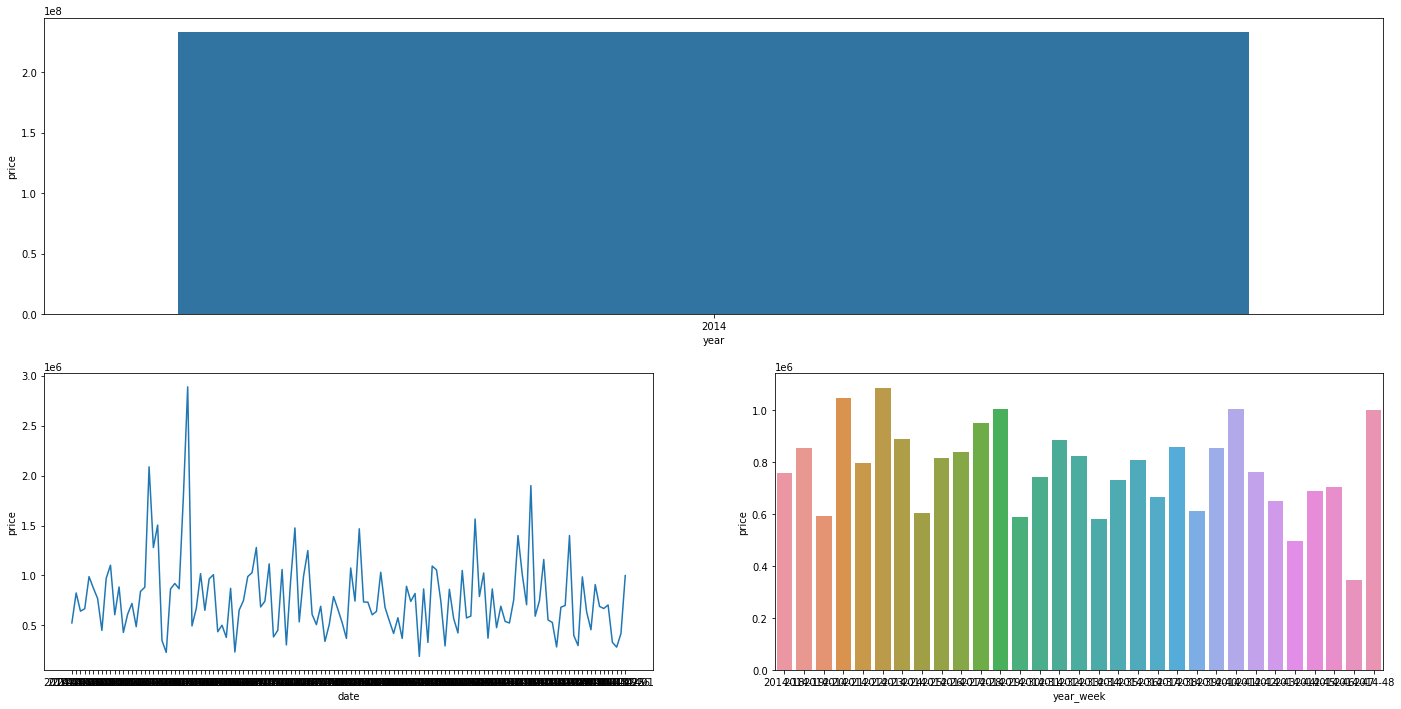

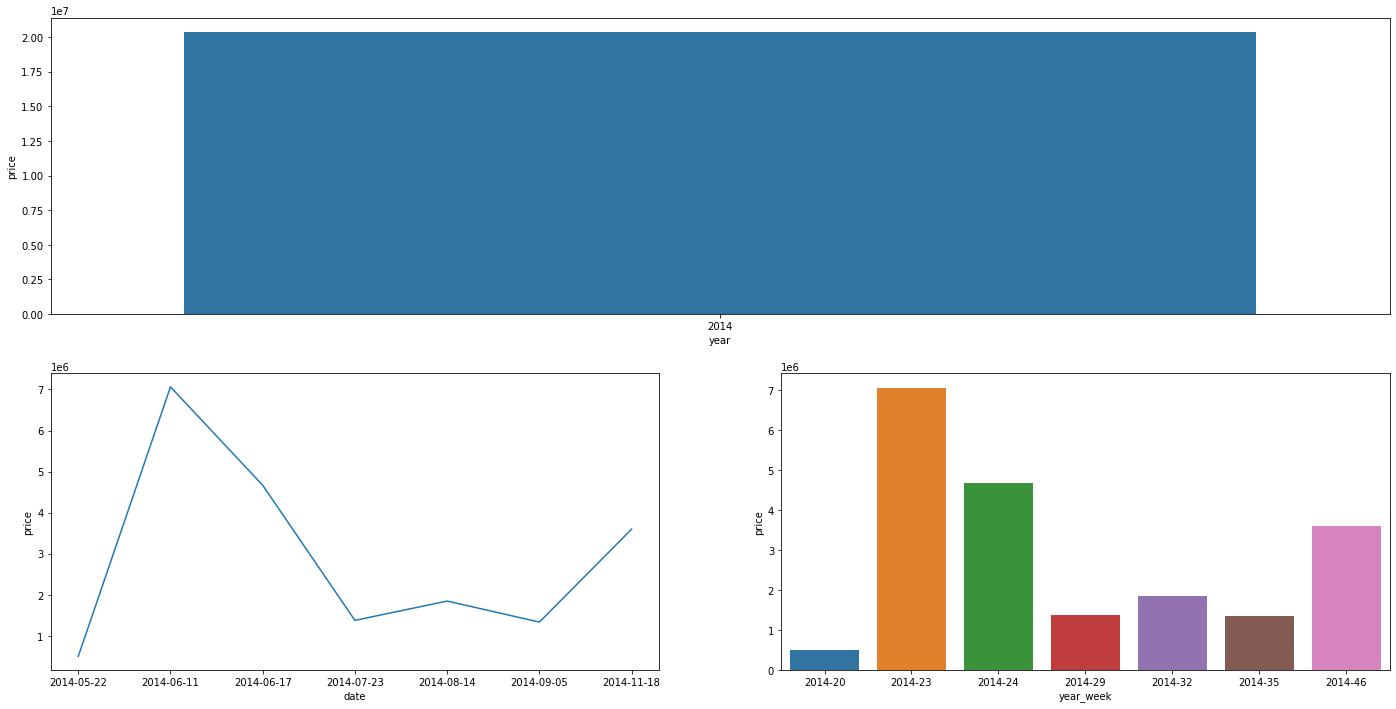

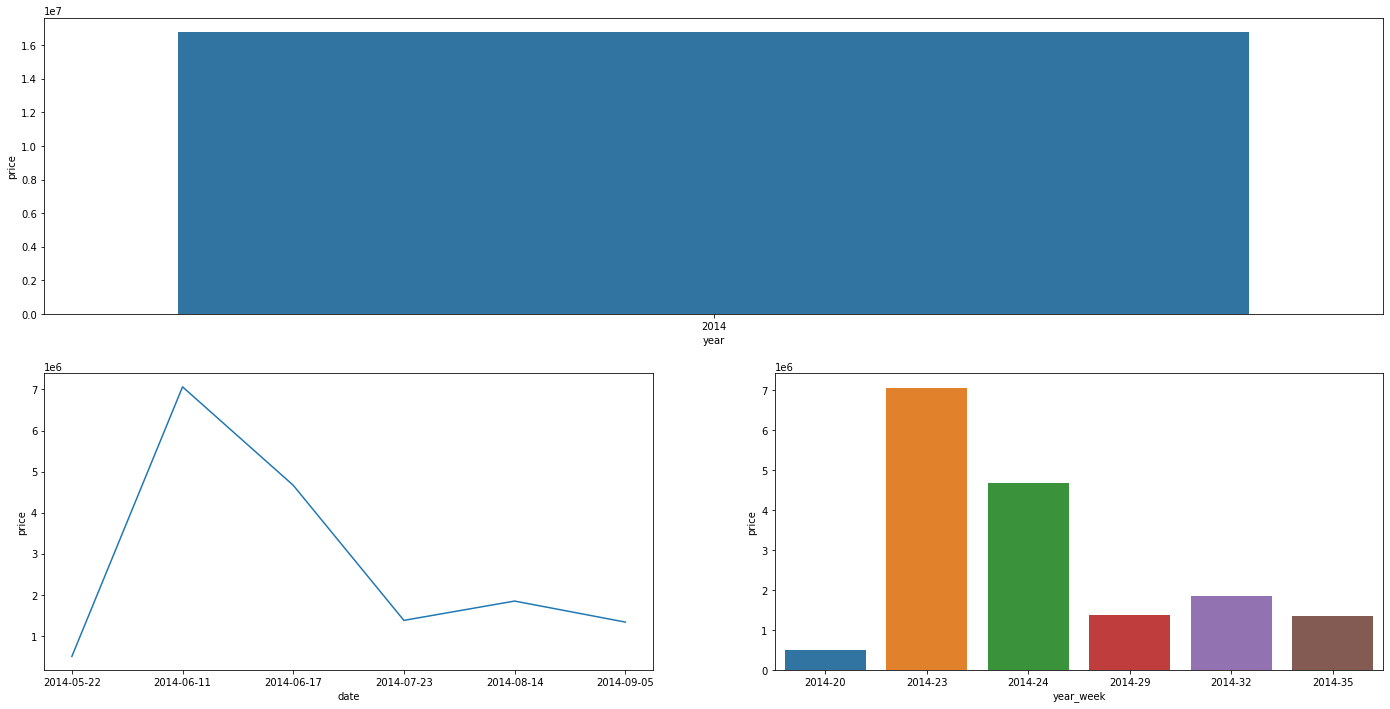

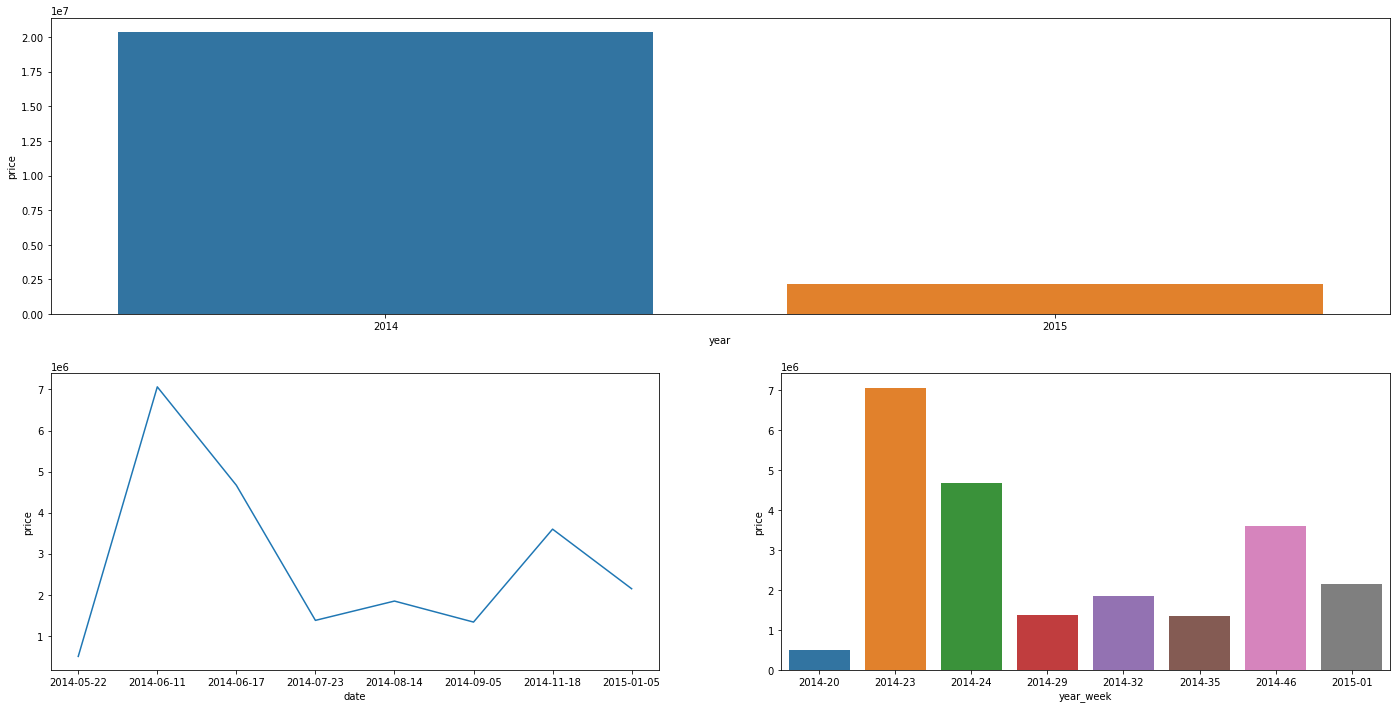

In [73]:
widgets.interactive(update_map, 
                    data=fixed(data), 
                    date_limit=date_limit,
                    year_limit=year_limit, 
                    waterfront_limit=waterfront_limit)